# Differential-Drive Car Localization

The [differential-drive car](https://en.wikipedia.org/wiki/Differential_wheeled_robot) is a common mobile robot configuration. By independently controlling the velocities of its two wheels, the robot can translate and reorient on the plane. Its state vector is $\mathbf x = (x,y,\theta)$, it has two inputs $\mathbf u = (u_1,u_2)$ corresponding to the angular velocities of its two wheels, $\rho$ and $L$ are fixed parameters, and $\Delta t$ is the timestep duration.

You will be implementing Monte Carlo localization using the particle filter. The robot behaves according to models with nonlinear noise components and unknown to your estimators. The filters will assume a standard nonlinear motion model with additive Gaussian noise $\mathbf x_{k} = f(\mathbf x_{k-1}, \mathbf u_k) + \mathbf w_k$, where
$$\begin{align*}
    \mathbf x_k =
    \begin{bmatrix} x_{k} \\ y_{k} \\ \theta_{k} \end{bmatrix} =
    \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \theta_{k-1} \end{bmatrix} + \Delta t
    \begin{bmatrix} \frac{\rho}{2} \cos\theta_{k-1} (u_{1,k}+u_{2,k}) \\
    \frac{\rho}{2} \sin\theta_{k-1} (u_{1,k}+u_{2,k}) \\
    \frac{\rho}{L} (u_{2,k}-u_{1,k}) \end{bmatrix} + \mathbf w_k
\end{align*}$$
and $\mathbf w_k \sim \mathcal N(\mathbf 0, Q)$. 

The vehicle has a range and bearing sensor, which measures its distance $r_k$ and angle $\phi_k$ from $p$ fixed landmarks within the sensor's maximum range. Again, these will have both nonlinear model and noise components, but your estimators will assume the standard model $\mathbf z_k = h(\mathbf x_k) + \mathbf v_k$, where $h = (h_1,...,h_p)$,
$$\begin{align*}
    h_j(\mathbf x_k) = \begin{bmatrix} r_{j,k} \\ \phi_{j,k} \end{bmatrix} =
    \begin{bmatrix} \sqrt{(m_{j,x} - x_k)^2 + (m_{j,y} - y_k)^2} \\ \text{atan2} (m_{j,y} - y_k, m_{j,x} - x_k) - \theta_k \end{bmatrix} + \mathbf v_k
\end{align*}$$
and $\mathbf v_k \sim \mathcal N(\mathbf 0, R_k)$.


## Robot Functions

The following are quantities and functions describing the true robot model. You should not modify these.

*   `WHEEL1_NOISE`, `WHEEL2_NOISE`, and `BEARING_SENSOR_NOISE` are parameters describing the true robot model noise. *Your estimators should not make reference to these.*

*   `RHO` and `L` are known physical parameters of the robot as shown on the above figure. `MAX_RANGE` is the maximum range of the robot's sensor. `RFID` is a list of known landmark positions.

*   `Q` and `R` are covariance matrices used by your estimators.

*   The remaining variables describe the time interval, total simulation time, number of particles in the particle filter, and the animation plot limits.

*   The functions `control`, `move`, `measure` implement the "true" physics and behavior of the robot.

In [2]:
import math
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [3]:
# "True" robot noise (filters do NOT know these)
WHEEL1_NOISE = 0.05
WHEEL2_NOISE = 0.1
BEARING_SENSOR_NOISE = np.deg2rad(1.0)

# Physical robot parameters (filters do know these)
RHO = 1
L = 1
MAX_RANGE = 15    # maximum observation range

# RFID positions [x, y]
RFID = np.array([[-5.0, -5.0],
                 [10.0, 0.0],
                 [10.0, 10.0],
                 [0.0, 15.0],
                 [-5.0, 20.0]])

# Covariances used by the estimators
Q = np.diag([0.1, 0.1, np.deg2rad(10.0)]) ** 2
R = np.diag([1.0, np.deg2rad(10.0)]) ** 2

# Other parameters
DT = 0.1         # time interval [s]
SIM_TIME = 30.0  # simulation time [s]

# Plot limits
XLIM = [-20,20]
YLIM = [-10,30]

In [4]:
"""
Robot physics
"""
def control(time, x):
    # Control inputs to the robot at a given time for a given state
    psi1dot = 3.7
    psi2dot = 4.0
    return np.array([psi1dot, psi2dot])

def move(x, u):
    # Physical motion model of the robot: x_k = f(x_{k-1}, u_k)
    # Incorporates imperfections in the wheels
    theta = x[2]
    psi1dot = u[0] * (1 + np.random.rand() * WHEEL1_NOISE)
    psi2dot = u[1] * (1 + np.random.rand() * WHEEL2_NOISE)

    velocity = np.array([RHO/2 * np.cos(theta) * (psi1dot+psi2dot),
                         RHO/2 * np.sin(theta) * (psi1dot+psi2dot),
                         RHO/L * (psi2dot - psi1dot)])

    return x + DT * velocity

def measure(x):
    # Physical measurement model of the robot: z_k = h(x_k)
    # Incorporates imperfections in both range and bearing sensors
    z = {}

    for i in range(RFID.shape[0]):
        dx = RFID[i, 0] - x[0]
        dy = RFID[i, 1] - x[1]
        r = math.sqrt(dx**2 + dy**2)
        phi = math.atan2(dy, dx) - x[2]

        if r <= MAX_RANGE:
            z[i] = np.array([np.round(r),
                             phi + np.random.randn() * BEARING_SENSOR_NOISE])

    return z

## Plotting and Animation

The following code will help us visualize the results of the particle filter. You should not modify these.

In [5]:
def run_PF(num_particles):
    time = 0.0

    # Initialize state
    h_x_est = np.zeros((1,3))
    h_x_true = np.zeros((1,3))

    pf = ParticleFilter(num_particles)
    all_particles = [pf.particles]
    landmarks_seen = [[]]

    while time <= SIM_TIME:
        time += DT
        u = control(time, h_x_true[-1])
        x_true = move(h_x_true[-1], u)
        z = measure(x_true)

        pf.predict(u)
        pf.update(z)
        if np.sum(pf.weights) == 0:
            pf.generate_particles()
        pf.resample()

        # store data history
        x_est = np.sum(pf.weights * pf.particles.T, axis=1)
        h_x_est = np.vstack((h_x_est, x_est))
        h_x_true = np.vstack((h_x_true, x_true))
        all_particles.append(pf.particles)
        landmarks_seen.append(z.keys())

    plt.figure()
    errors = np.abs(h_x_true - h_x_est)
    plt.plot(errors)
    dth = errors[:,2] % (2*np.pi)
    errors[:,2] = np.amin(np.array([2*np.pi-dth, dth]), axis=0)
    plt.legend(['x error', 'y error', 'th error'])
    plt.xlabel('time')
    plt.ylabel('error magnitude')
    plt.show()

    return h_x_true, h_x_est, all_particles, landmarks_seen

In [6]:
def animate_pf(h_x_true, h_x_est, all_particles, landmarks_seen):
    def animate(frame):
        true.set_data(np.array(h_x_true[:frame,0]).flatten(), np.array(h_x_true[:frame,1]).flatten())
        est.set_data(np.array(h_x_est[:frame,0]).flatten(), np.array(h_x_est[:frame,1]).flatten())
        particles.set_data(all_particles[frame][:,0], all_particles[frame][:,1])

        for r in range(RFID.shape[0]):
            if r in landmarks_seen[frame]:
                RFID_lines[r].set_data([h_x_true[frame,0], RFID[r,0]], [h_x_true[frame,1], RFID[r,1]])
            else:
                RFID_lines[r].set_data([], [])

    fig, ax = plt.subplots()

    landmarks = ax.plot(RFID[:,0], RFID[:,1], "*k", label='landmark to robot')
    ax.scatter([h_x_true[0,0]], [h_x_true[0,1]], marker='.', color='blue', s=50, label='start')
    ax.scatter([h_x_true[-1,0]], [h_x_true[-1,1]], marker='x', color='blue', s=50)
    ax.scatter([h_x_est[-1,0]], [h_x_est[-1,1]], marker='x', color='red', s=50)

    true, = ax.plot([], [], "-b", label='true trajectory')
    est, = ax.plot([], [], "--r", label='estimated trajectory')
    particles, = ax.plot([], [], ".g")
    RFID_lines = []
    for r in range(RFID.shape[0]):
        line, = ax.plot([], [], "-.k")
        RFID_lines.append(line)

    ax.axis('equal')
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    ax.grid()
    ax.legend()

    anim = animation.FuncAnimation(fig, animate, frames=h_x_true.shape[0])
    return anim

# Part 1: Particle Filter Localization

Your first task is to complete the `ParticleFilter` class below. It implements the main procedures of a particle filter: `predict()` for motion prediction, `update()` for likelihood weighting, and `resample()` for resampling particles. All of these methods can directly update the `particles` and `weights` fields stored in the class.

* `predict()` should apply the motion model to each particle. You can use [`numpy.random.multivariate_normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html) to simulate $\mathbf w_k$.

* `update()` computes the cumulative measurement likelihood for each particle and multiplies it by the current weight stored in `self.weights`. The measurement `z` is a dictionary mapping RFID index to observed range and bearing, and you can also compute each particle's predicted range and bearing to a given landmark. To compute likelihood, you can use `numpy.random.multivariate_normal.pdf`.

* `resample()` uses the current `self.samples` and `self.weights` to resample a new set of samples. You can simply use [`numpy.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to do this. Be sure to reset `self.weights` to a uniform distribution as well (as is done in `generate_particles()`).

To improve efficiency, we **highly** recommend that you use array operations whenever possible. While not required, you should be able to implement all methods without processing each particle individually via a loop.

In [7]:
class ParticleFilter():
    def __init__(self, num_particles):
        self.num_particles = num_particles
        self.generate_particles()
    

    def generate_particles(self):
        # Generate a set of particles with uniform weights
        p_x = np.random.uniform(XLIM[0], XLIM[1], self.num_particles)
        p_y = np.random.uniform(YLIM[0], YLIM[1], self.num_particles)
        p_th = np.random.uniform(-np.pi, np.pi, self.num_particles)

        self.particles = np.vstack((p_x, p_y, p_th)).T
        self.weights = np.ones(self.num_particles) / self.num_particles


    def predict(self, u):
        """
        :param u: Control (u1, u2) [size 3 array]
        Perform motion prediction for all particles and update self.particles in place
        """
        #use actual motion model
        for i in range(self.num_particles):
            theta = self.particles[i][2]
            psi1dot = u[0]
            psi2dot = u[1]
            velocity = np.array([RHO/2 * np.cos(theta) * (psi1dot+psi2dot),
                            RHO/2 * np.sin(theta) * (psi1dot+psi2dot),
                            RHO/L * (psi2dot - psi1dot)])
            
            w_k = np.random.multivariate_normal(mean=[0, 0, 0], cov=Q)
            self.particles[i] = self.particles[i] + DT * velocity + w_k
            
    def update(self, z):
        """
        :param z: Sensor measurement dictionary {RFID idx: [range, bearing]}
        Perform measurement update for all particles and update self.weights in place
        """
        for i, particle in enumerate(self.particles):
            weight = 1.0
            for landmark_idx, measure in z.items():
                dx = RFID[landmark_idx, 0] - particle[0]
                dy = RFID[landmark_idx, 1] - particle[1] 
                r = np.round(np.sqrt(dx ** 2 + dy ** 2))
                phi = math.atan2(dy, dx) - particle[2]
                mean = [r, phi]
                temp_weight = multivariate_normal.pdf(measure, mean, cov=R)
                weight *= temp_weight
            self.weights[i] *= weight
        

    def resample(self):
        """
        Resample particle set. Assign new partices to self.particles 
        and reset self.weights to all ones.
        """
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, replace=True, p=self.weights/self.weights.sum())
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles
        

Once you have finished your implementation, you can invoke `run_PF()` below with the number of particles as an argument. As the particle filter runs, the estimated state is computed as the mean of all particles, and the absolute error between the estimated and true state (in each component) is plotted over time.

You can also generate an animation of the robot's motion over time with the particles overlaid on the plot. As the robot moves, it traces out both the actual and estimated trajectory. Dashed lines also indicate when the robot senses the various landmarks. The behavior of the particles should generally match what you see on the error plot.

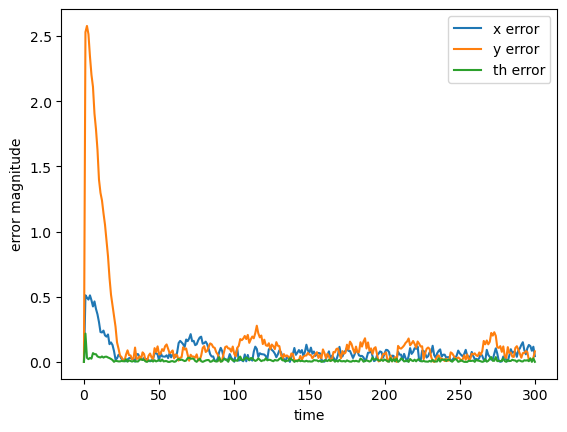

In [8]:
h_x_true, h_x_est, all_particles, landmarks_seen = run_PF(500)

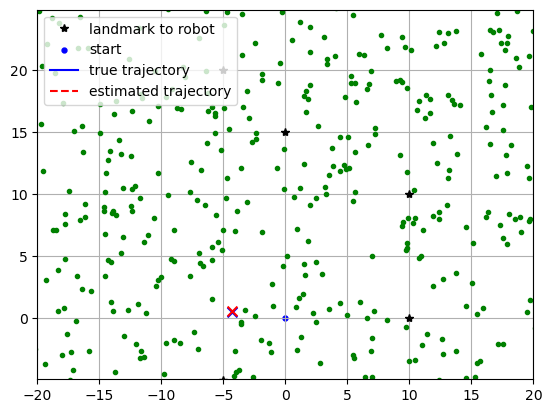

In [9]:
anim = animate_pf(h_x_true, h_x_est, all_particles, landmarks_seen)
HTML(anim.to_html5_video())

# Part 2: Particle Filter Discussion

Briefly answer each of the questions below. We recommend that you output one animation at a time to keep the kernel stable. You can omit the animations from your submission, but please include all error plots.

1. Run the particle filter with 500 particles and the default parameters a few times. You should observe that the estimation looks somewhat erratic with particles everywhere at the beginning, followed by a convergence to near the true robot state if the filter is working properly. Explain this particle behavior and show a plot of the estimation errors.

2. The maximum range of the sensor is currently 15. Set `MAX_RANGE` to 10 and rerun the particle filter. Show the resultant error plot and explain the change to the overall estimation accuracy as well as any transient effects that appear.

3. Set `MAX_RANGE` back to 15 and rerun the particle filter, this time with just 10 particles. Show the resultant error plot and explain the change to the overall estimation accuracy as well as any transient effects that appear.



1. See error plots and animation above. As time passes and the particles are resampled with the weighted measurements, they particles get closer and closer to the true position of the robot. 

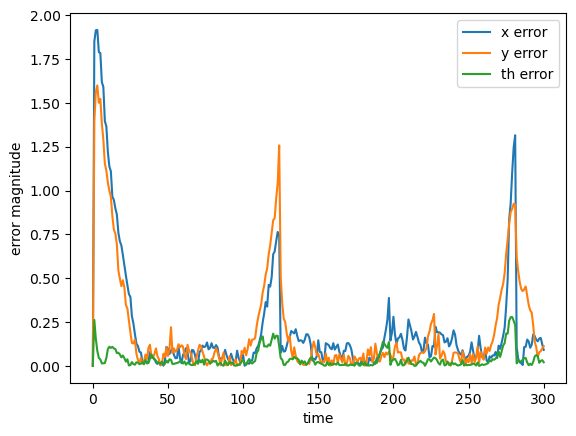

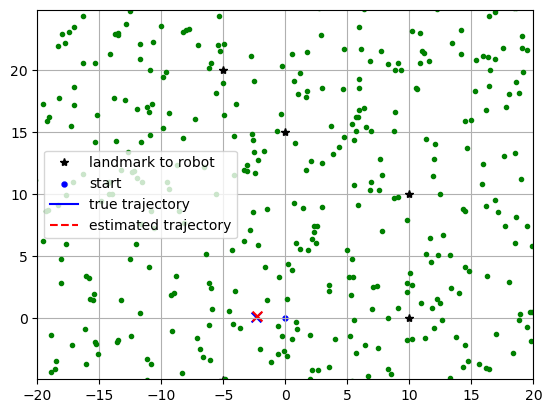

In [10]:
MAX_RANGE = 10
h_x_true, h_x_est, all_particles, landmarks_seen = run_PF(500)
anim = animate_pf(h_x_true, h_x_est, all_particles, landmarks_seen)
HTML(anim.to_html5_video())

2. The error plot peaks at several time steps after the initial convergence. At those time steps, the particles spread out and then re converge. These correspond to when the robot is far/out of range from a landmark and cannot get an accurate sensor reading. One the robot gets closer to a landmark, the particles reconverge and the error decreases. 

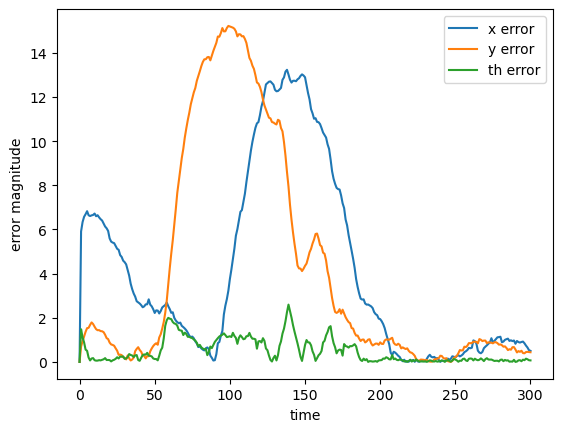

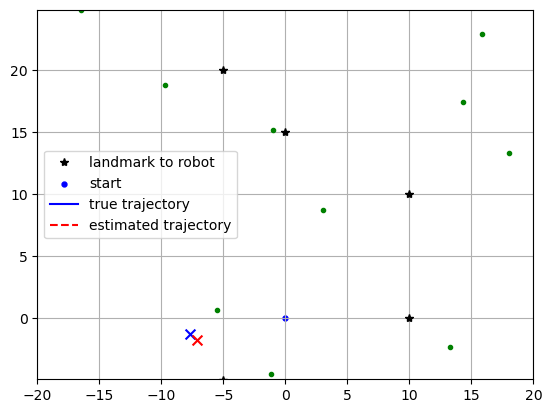

In [11]:
MAX_RANGE = 15
h_x_true, h_x_est, all_particles, landmarks_seen = run_PF(10)
anim = animate_pf(h_x_true, h_x_est, all_particles, landmarks_seen)
HTML(anim.to_html5_video())

3. The particles don't converge to the true location of the robot. For most of the simulation, the error in both the x and y directions is quite high. It's only towards the end of the simulation that the particles get closer to the true location of the robot. Since there are very few particles, the mean location will be biased, resulting in an inaccurate prediction. 